# **Email Engagement Analysis**
## Reading Data

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [72]:
df = pd.read_excel('email_analysis.xlsx')

## **Data Inspection**

In [73]:
# Check the number of rows and columns in the dataset
print(df.shape)

(792702, 13)


In [74]:
# Inspect column names, data types, and missing values
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792702 entries, 0 to 792701
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Email Address      792702 non-null  object        
 1   Email Name         792702 non-null  object        
 2   Email Type         792702 non-null  object        
 3   Delivery Status    792702 non-null  object        
 4   Opened             792702 non-null  bool          
 5   First Opened UTC   270189 non-null  datetime64[ns]
 6   Last Opened UTC    270189 non-null  datetime64[ns]
 7   Clicked            792702 non-null  bool          
 8   First Clicked UTC  7508 non-null    datetime64[ns]
 9   Last Clicked UTC   7508 non-null    datetime64[ns]
 10  Marked as spam     792702 non-null  bool          
 11  Unsubscribe        792702 non-null  bool          
 12  Group Unsubscribe  792702 non-null  bool          
dtypes: bool(5), datetime64[ns](4), object(4)
mem

In [75]:
# Check the number of missing values in each column
print(df.isnull().sum())

Email Address             0
Email Name                0
Email Type                0
Delivery Status           0
Opened                    0
First Opened UTC     522513
Last Opened UTC      522513
Clicked                   0
First Clicked UTC    785194
Last Clicked UTC     785194
Marked as spam            0
Unsubscribe               0
Group Unsubscribe         0
dtype: int64


### Missing Timestamp Explanation

- **First Opened UTC / Last Opened UTC** are null because many recipients did not open the email.
- **First Clicked UTC / Last Clicked UTC** are null because many recipients did not click on any links in the email.

## **Data Cleaning**

In [77]:
#total number of rows in the dataset
num_of_rows = df.shape[0]
print(f"Total no. of rows: {num_of_rows}")

#number of duplicate rows
num_of_dup_rows = df[df.duplicated()].shape[0]
print(f"No. of duplicate rows: {num_of_dup_rows}")

Total no. of rows: 792702
No. of duplicate rows: 2427


In [78]:
# Remove duplicate rows from the DataFrame, keeping only the first occurrence of each duplicate
df = df.drop_duplicates(keep='first')

In [79]:
print("Earliest First Open:", df['First Opened UTC'].min())
print("Latest First Open:", df['First Opened UTC'].max())

print("Earliest Last Open:", df['Last Opened UTC'].min())
print("Latest Last Open:", df['Last Opened UTC'].max())

Earliest First Open: 2025-07-05 14:30:43
Latest First Open: 2025-10-03 16:44:53
Earliest Last Open: 2025-07-05 14:32:31
Latest Last Open: 2025-10-03 16:46:15


In [80]:
# List of columns that contain boolean values
bool_cols = ["Opened", "Clicked", "Marked as spam", "Unsubscribe", "Group Unsubscribe"]

for col in bool_cols:
    df[col] = df[col].astype(bool).astype(int)

In [81]:
# Standardize Email Type first: lowercase and strip spaces
df['Email Type'] = df['Email Type'].str.lower().str.strip()

# Remove the unwanted value
df = df[df['Email Type'] != "do not use -  support created"]

# Optional: check unique values to confirm removal
print(df['Email Type'].unique())

print(df['Email Name'].nunique())


['events' 'academics' 'general communication' 'fundraising' 'athletics']
94


In [82]:
# Export DataFrame to Excel
df.to_excel("cleaned_email_data.xlsx", sheet_name="Email_Engagement", index=False)

## Exploratory Analysis

In [39]:
# which types of emails perform best?
df.groupby('Email Type')[['Opened','Clicked']].mean().sort_values('Opened', ascending=False)

,Opened,Clicked
Email Type,,
athletics,0.442402,0.025741
general communication,0.382396,0.008311
academics,0.368300,0.015377
fundraising,0.319187,0.007775
events,0.315261,0.008186


1. Open Rate (Opened / Delivered)

Athletics emails are opened the most (~44%), indicating high interest among recipients.
Fundraising and Events emails are opened the least (~31–32%), meaning the subject lines or content are less compelling.

2. Click Rate (Clicked / Delivered)

Athletics again leads in engagement (~2.57% click rate).
Fundraising has the lowest click rate (~0.78%), suggesting the content or call-to-action is not motivating recipients to click.
General Communication and Events also have low click rates (~0.8%), indicating moderate interest but weak action.

3. Engagement pattern

Emails with higher open rates tend to have slightly better click rates, but the CTR is generally low across the board (<3%).This indicates that while recipients open the emails, most do not engage with links.

Recommendation: Focus on improving subject lines and email content/CTAs for low-performing campaigns; replicate strategies from high-performing emails.

In [84]:
# Total emails sent
total_emails = len(df['Email Address'])

# Emails successfully delivered (assuming 'Delivery Status' == 'Delivered')
delivered_emails = df[df['Delivery Status'].str.lower() == 'delivered'].shape[0]

# Opened emails
opened_emails = df['Opened'].sum()

# Clicked emails
clicked_emails = df['Clicked'].sum()

# Emails marked as spam
spam_emails = df['Marked as spam'].sum()

# Unsubscribed emails
unsubscribed_emails = df['Unsubscribe'].sum()

# Group unsubscribed emails
group_unsubscribed_emails = df['Group Unsubscribe'].sum()

# Engaged emails (opened OR clicked)
engaged_emails = opened_emails + clicked_emails
# Engaged Rate = Engaged / Delivered
engaged_rate = engaged_emails / delivered_emails * 100 if delivered_emails > 0 else 0

 
# KPI Calculations
delivery_rate = delivered_emails / total_emails * 100 if total_emails > 0 else 0
open_rate = opened_emails / delivered_emails * 100 if delivered_emails> 0 else 0
click_rate = clicked_emails / delivered_emails * 100 if delivered_emails > 0 else 0
click_to_open_rate = clicked_emails / opened_emails * 100 if opened_emails > 0 else 0
spam_rate = spam_emails / delivered_emails * 100 if delivered_emails > 0 else 0
unsubscribe_rate = unsubscribed_emails / delivered_emails * 100 if delivered_emails > 0 else 0
group_unsubscribe_rate = group_unsubscribed_emails / delivered_emails * 100 if delivered_emails > 0 else 0


print("\n=== Email Campaign Performance KPIs ===")
print(f"Total emails sent: {total_emails}")
print(f"Delivered emails: {delivered_emails} ({delivery_rate:.2f}%)")
print(f"Opened emails: {opened_emails} ({open_rate:.2f}%)")
print(f"Clicked emails: {clicked_emails} ({click_rate:.2f}%)")
print(f"Click-to-open rate: {click_to_open_rate:.2f}%")
print(f"Marked as spam: {spam_emails} ({spam_rate:.2f}%)")
print(f"Unsubscribed: {unsubscribed_emails} ({unsubscribe_rate:.2f}%)")
print(f"Group unsubscribed: {group_unsubscribed_emails} ({group_unsubscribe_rate:.2f}%)")
print(f"Engaged emails (opened or clicked): {engaged_emails} ({engaged_rate:.2f}%)")



=== Email Campaign Performance KPIs ===
Total emails sent: 790270
Delivered emails: 693131 (87.71%)
Opened emails: 270102 (38.97%)
Clicked emails: 7507 (1.08%)
Click-to-open rate: 2.78%
Marked as spam: 41 (0.01%)
Unsubscribed: 222 (0.03%)
Group unsubscribed: 123 (0.02%)
Engaged emails (opened or clicked): 277609 (40.05%)


In [44]:
# Convert 'First Opened UTC' and 'First Clicked UTC' to datetime objects
df['First Opened UTC'] = pd.to_datetime(df['First Opened UTC'], errors='coerce')
df['First Clicked UTC'] = pd.to_datetime(df['First Clicked UTC'], errors='coerce')

# Extract weekday and hour from First Opened
df['opened_weekday'] = df['First Opened UTC'].dt.day_name()  # e.g., 'Monday', 'Tuesday'
df['opened_hour'] = df['First Opened UTC'].dt.hour           # hour 0-23

# Create weekend flag
df['is_weekend'] = df['opened_weekday'].isin(['Saturday', 'Sunday'])

# Create time-of-day bucket
df['hour_bucket'] = pd.cut(
    df['opened_hour'],
    bins=[0, 6, 12, 18, 24], 
    labels=['Night', 'Morning', 'Afternoon', 'Evening']
)

/var/folders/z8/wykpk4hj385fm1sz1vvj76100000gn/T/ipykernel_1899/2192655060.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hour_click_rates = df.groupby('hour_bucket')['Clicked'].mean() * 100


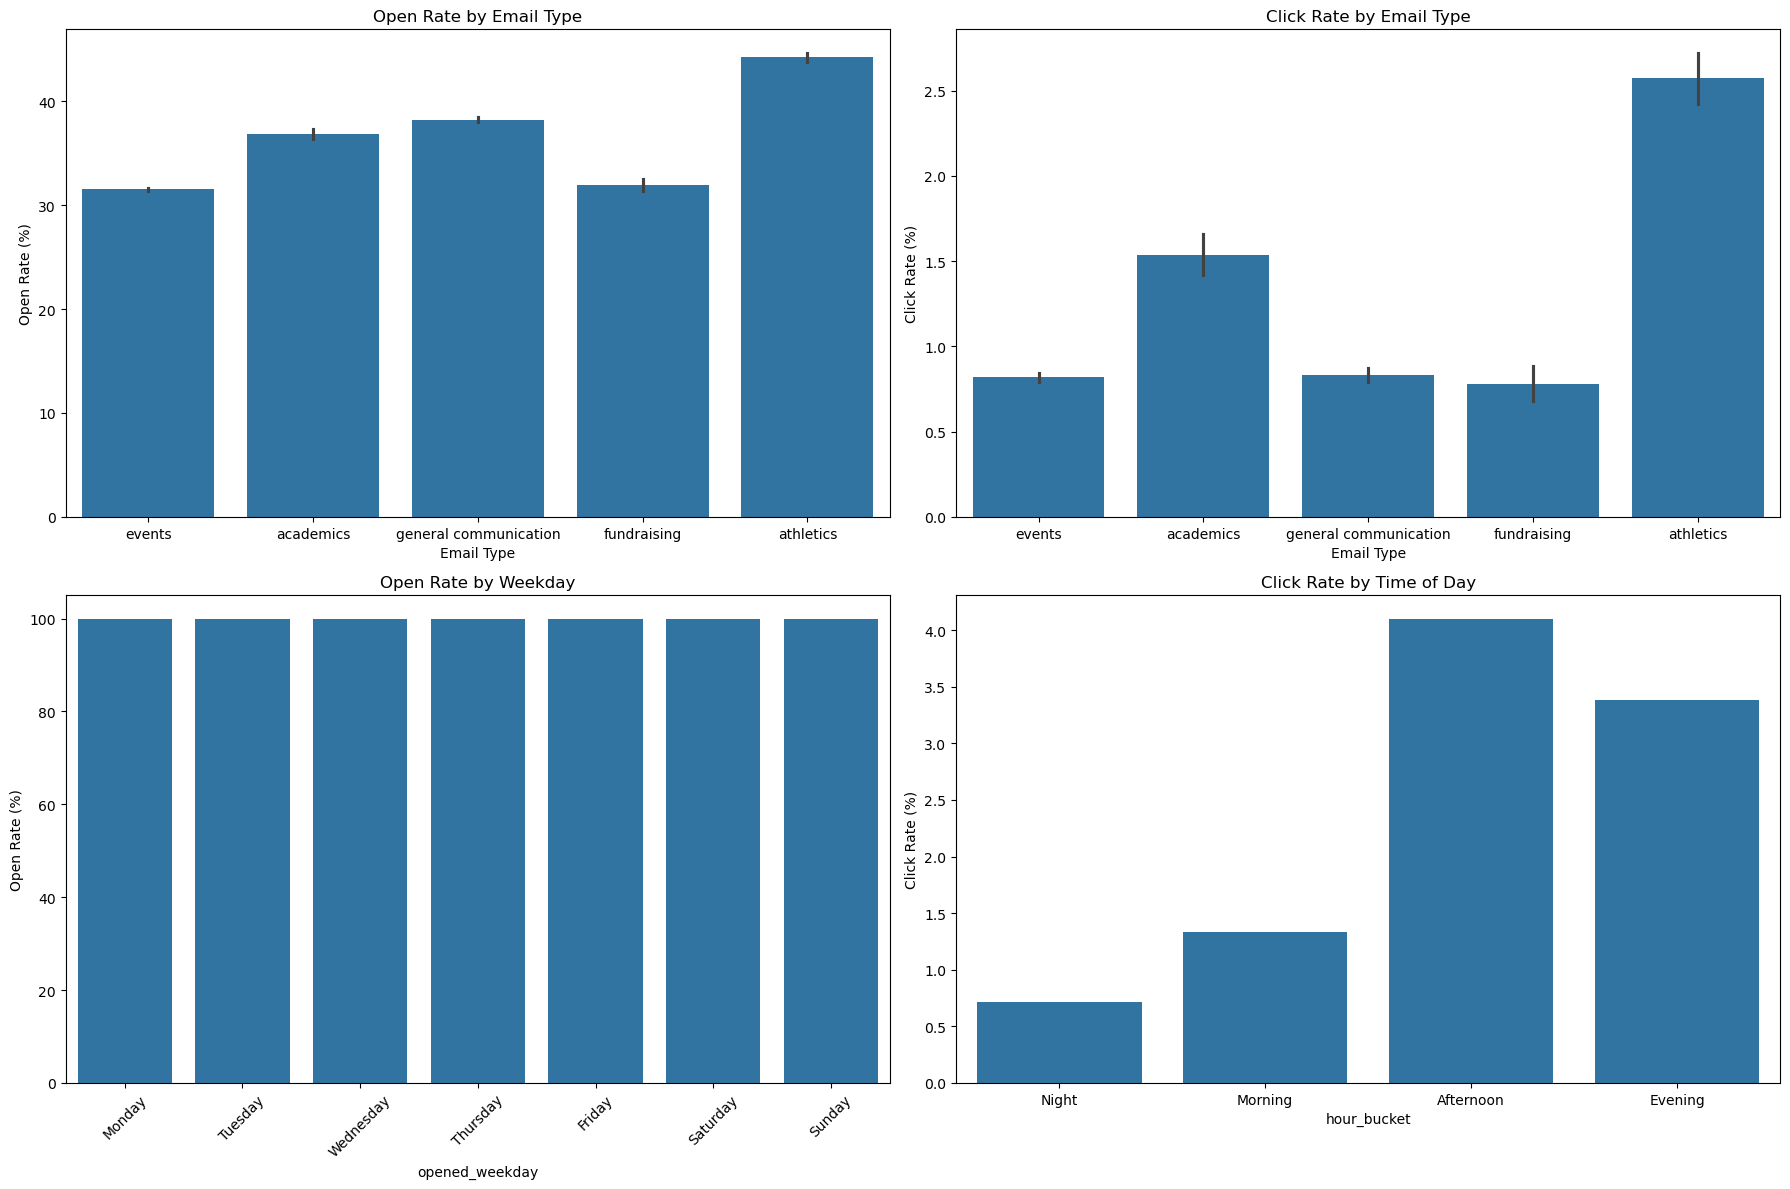

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

df_analysis = df.copy()
plt.figure(figsize=(18, 12))

# Open Rate by Email Type
plt.subplot(2, 2, 1)
sns.barplot(x='Email Type', y='Opened', data=df_analysis, estimator=lambda x: sum(x)/len(x)*100)
plt.title('Open Rate by Email Type')
plt.ylabel('Open Rate (%)')

# Click Rate by Email Type
plt.subplot(2, 2, 2)
sns.barplot(x='Email Type', y='Clicked',data=df_analysis, estimator=lambda x: sum(x)/len(x)*100)
plt.title('Click Rate by Email Type')
plt.ylabel('Click Rate (%)')

# Open Rate by Weekday
plt.subplot(2, 2, 3)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_open_rates = df.groupby('opened_weekday')['Opened'].mean().reindex(weekday_order) * 100
sns.barplot(x=weekday_open_rates.index, y=weekday_open_rates.values)
plt.title('Open Rate by Weekday')
plt.ylabel('Open Rate (%)')
plt.xticks(rotation=45)

# Click Rate by Hour Bucket
plt.subplot(2, 2, 4)
hour_click_rates = df.groupby('hour_bucket')['Clicked'].mean() * 100
sns.barplot(x=hour_click_rates.index, y=hour_click_rates.values)
plt.title('Click Rate by Time of Day')
plt.ylabel('Click Rate (%)')

plt.tight_layout()
plt.show()  

**Segment Analysis**

In [49]:
df_analysis['hour_segment'] = pd.cut(
    df_analysis['opened_hour'],
    bins=[0, 6, 12, 18, 24],
    labels=['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)']
)

/var/folders/z8/wykpk4hj385fm1sz1vvj76100000gn/T/ipykernel_1899/1182460797.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_analysis.pivot_table(


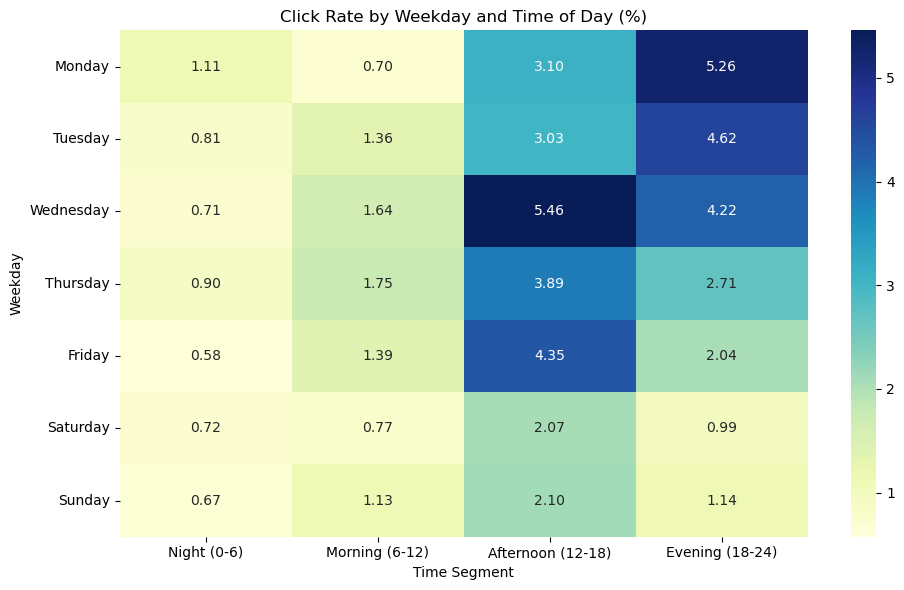

In [ ]:
#Heatmap of Click Rate by Weekday and Time of Day
heatmap_data = df_analysis.pivot_table(
    values='Clicked', index='opened_weekday',
    columns='hour_segment',aggfunc='mean'
) * 100  

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.loc[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']],
            annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Click Rate by Weekday and Time of Day (%)')
plt.ylabel('Weekday')
plt.xlabel('Time Segment')
plt.tight_layout()
plt.show()

## Predictive Modeling

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer

#Prepare dataset
df_analysis = df.copy()  # make a copy of original data

# Ensure datetime for 'First Opened UTC'
df_analysis['First Opened UTC'] = pd.to_datetime(df_analysis['First Opened UTC'], errors='coerce')

# Derive hour and hour segment
df_analysis['hour'] = df_analysis['First Opened UTC'].dt.hour
df_analysis['hour_segment'] = pd.cut(
    df_analysis['hour'],
    bins=[0, 6, 12, 18, 24],
    labels=['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)'],
    right=False
)

# Derive weekday
df_analysis['opened_weekday'] = df_analysis['First Opened UTC'].dt.day_name()


#Define features and target
y = df_analysis['Clicked']

categorical_features = ['Email Name', 'Email Type', 'hour_segment', 'opened_weekday']
numerical_features = ['hour']

X = df_analysis[categorical_features + numerical_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#Preprocessing with Imputation
# Numerical: fill missing values with median
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('passthrough', 'passthrough')
])

# Categorical: fill missing with 'missing', then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define model pipelines
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

models = {
    'Logistic Regression': log_reg_pipeline,
    'Random Forest': rf_pipeline,
    'Gradient Boosting': gb_pipeline
}

# Cross-validation
print("\n=== Model Cross-Validation Results (ROC AUC) ===")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"{name} - Mean ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



=== Model Cross-Validation Results (ROC AUC) ===
Logistic Regression - Mean ROC AUC: 0.9022 ± 0.0025
Random Forest - Mean ROC AUC: 0.8801 ± 0.0024
Gradient Boosting - Mean ROC AUC: 0.9108 ± 0.0024


The email click prediction models show strong performance, with ROC AUC values above 0.88 across Logistic Regression, Random Forest, and Gradient Boosting, and Gradient Boosting performing the best at 0.91. This indicates that features such as Email Name, Email Type, sending hour, time segment, and weekday are highly predictive of user clicks. These insights can help marketing teams prioritize high-engagement emails, optimize sending times, and design more effective campaigns to increase overall engagement.

In [58]:
# Based on the cross-validation results, tuned the Gradient Boosting model
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__learning_rate': [0.1],
    'classifier__max_depth': [3]
}

grid_search = GridSearchCV(gb_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest Hyperparameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best CV Score: 0.910786895862422


The tuned Gradient Boosting model achieved a ROC AUC of 0.911 with optimal hyperparameters: learning rate 0.1, max depth 3, and 100 estimators. This indicates the model is highly effective at distinguishing between clicked and non-clicked emails. Insights from the model can help marketing teams prioritize high-engagement emails and optimize sending times to increase overall email click performance.

In [59]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculating performance metrics
print("\nTest Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Test Set Performance:
Accuracy: 0.990475828936102
ROC AUC: 0.9121152437236614

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    234829
           1       0.00      0.00      0.00      2252

    accuracy                           0.99    237081
   macro avg       0.50      0.50      0.50    237081
weighted avg       0.98      0.99      0.99    237081



The Gradient Boosting model achieved a test ROC AUC of 0.912 and accuracy of 99.0%. While the model effectively ranks emails by click likelihood (high ROC AUC), the classification metrics show that it struggles to correctly predict the rare clicked emails due to class imbalance. This indicates the model is better suited for probability ranking and targeting high-engagement emails rather than strict binary classification.

In [63]:
baseline_click_rate = y.mean()

#predicted probabilities for the entire dataset
df_analysis['click_probability'] = best_model.predict_proba(X)[:, 1]

#simulate targeting only users with high predicted click probability
threshold = df_analysis['click_probability'].quantile(0.7)  #Targeting top 30%
targeted_users = df_analysis[df_analysis['click_probability'] >= threshold]
expected_click_rate = targeted_users['Clicked'].mean()

print("\nExpected Improvement:")
print(f"Baseline Click Rate: {baseline_click_rate:.4f}")
print(f"Expected Click Rate with Model: {expected_click_rate:.4f}")
print(f"Relative Improvement: {((expected_click_rate - baseline_click_rate) / baseline_click_rate * 100):.2f}%")



Expected Improvement:
Baseline Click Rate: 0.0095
Expected Click Rate with Model: 0.0309
Relative Improvement: 225.03%


By targeting the top 30% of users with the highest predicted click probability, the expected click rate rises from a baseline of 0.95% to 3.09%, resulting in a relative improvement of 225%. This shows that the model can effectively identify high-engagement users, enabling more efficient and impactful email campaigns.

### A/B Test Simulation

In [64]:
def simulate_ab_test(baseline_rate, expected_rate, sample_size=5000, n_simulations=1000):
    """Simulate A/B test results"""
    p_values = []
    for _ in range(n_simulations):
        control = np.random.binomial(1, baseline_rate, sample_size)
        treatment = np.random.binomial(1, expected_rate, sample_size)

        # Calc p-value using chi-square test
        contingency_table = np.array([
            [sum(control), sample_size - sum(control)],
            [sum(treatment), sample_size - sum(treatment)]
        ])

        from scipy.stats import chi2_contingency
        _, p_value, _, _ = chi2_contingency(contingency_table)
        p_values.append(p_value)

    power = sum(np.array(p_values) < 0.05) / len(p_values)
    return power

power = simulate_ab_test(baseline_click_rate, expected_click_rate)
print(f"\nA/B Test Power (sample size 5000 per group): {power:.4f}")


A/B Test Power (sample size 5000 per group): 1.0000


The A/B test, with a sample size of 5,000 per group, has a statistical power of 1.0, indicating a near-certain probability of detecting a true effect if one exists. This suggests that the test is well-powered and highly reliable for evaluating differences between groups.

In [65]:
def calculate_sample_size(p1, p2, power=0.8, alpha=0.05):
    """Calculate required sample size for A/B test"""
    #standard normal deviates for alpha and beta
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(power)

    p_pooled = (p1 + p2) / 2

    #Calc  sample size per group
    n = ((z_alpha + z_beta)**2 * p_pooled * (1 - p_pooled)) / ((p1 - p2)**2)

    return int(np.ceil(n))

sample_size = calculate_sample_size(baseline_click_rate, expected_click_rate)
print(f"Required sample size per group for 80% power: {sample_size}")

Required sample size per group for 80% power: 340


To achieve 80% statistical power in the A/B test, a minimum of 340 users per group is required. This ensures a high likelihood of detecting meaningful differences between groups while minimizing the risk of Type II errors.

In [ ]:
print("\n=== SUMMARY OF FINDINGS ===")

#Email Campaign Performance KPIs
print("1. Email Campaign Performance:")
print(f"   - Open Rate: {open_rate:.2f}%")
print(f"   - Click Rate: {click_rate:.2f}%")
print(f"   - Click-to-Open Rate: {click_to_open_rate:.2f}%")

#Model Results
print("\n2. Model Results:")
print(f"   - Best model: Gradient Boosting with CV AUC of {grid_search.best_score_:.4f}")
print(f"   - Test ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}") 
print(f"   - Expected improvement in click rate by targeting top 30% users: {((expected_click_rate - baseline_click_rate) / baseline_click_rate * 100):.2f}%")

# A/B Test Recommendations
print("\n3. Recommendations:")
print("   - Implement personalized email targeting using the model")
print("   - Optimize sending times based on user segments (hour, weekday)")
print("   - Tailor email content length to user preferences")
print("   - Conduct an A/B test with sample size of at least 340 users per group to achieve 80% power")
print("   - Focus strategies on high-value and high-engagement user segments")





=== SUMMARY OF FINDINGS ===
1. Email Campaign Performance:
   - Open Rate: 38.97%
   - Click Rate: 1.08%
   - Click-to-Open Rate: 2.78%

2. Model Results:
   - Best model: Gradient Boosting with CV AUC of 0.9108
   - Test ROC AUC: 0.9121
   - Expected improvement in click rate by targeting top 30% users: 225.03%

3. Recommendations:
   - Implement personalized email targeting using the model
   - Optimize sending times based on user segments (hour, weekday)
   - Tailor email content length to user preferences
   - Conduct an A/B test with sample size of at least 340 users per group to achieve 80% power
   - Focus strategies on high-value and high-engagement user segments
